# Training and evaluation of a neural network

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt

## Define the network architecture

### Define the neural network

In [2]:
def convert_to_tensor(data: DataFrame):   
    inputs = torch.tensor(data.drop("emotion", axis=1).to_numpy(dtype=np.float32))
    index2label = [label for label in data["emotion"].unique()]
    label2index = {label: index for index, label in enumerate(index2label)}
    labels = torch.tensor([label2index[label] for label in data["emotion"]], dtype=torch.long)
    return list(zip(inputs, labels))

In [3]:
class EmotionClassifierNN(nn.Module):
    def __init__(self, n_features:int = 20, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = nn.Sequential(
            nn.Linear(n_features, 45),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(45, 45),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(45, 45),
            nn.ReLU(),
            nn.Linear(45, 45),
            nn.ReLU(),
            nn.Linear(45, 4)
        )
    
    def forward(self, input):
        return self.net(input)

### Train the neural network

In [4]:
def train_nn(train_df: DataFrame, epochs: int = 100, batch_size: int = 256, learning_rate: float = 0.5, with_pca: bool = True) -> EmotionClassifierNN:    
    nn_model = EmotionClassifierNN(len(train_df.columns) - 1)

    train_data = convert_to_tensor(train_df)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nn_model.parameters(), lr=learning_rate)

    losses_per_epoch = []
    acc_per_epoch = []
    for epoch in range(epochs):
        losses = []
        correct_preds = 0
        for inputs, labels in train_loader:
            output = nn_model(inputs)
            optimizer.zero_grad()
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            correct_preds += torch.sum(torch.argmax(output, dim=1) == labels)
            losses.append(loss.item())
        print(f"Epoch {epoch+1}: loss: {np.mean(losses)}, accuracy: {correct_preds / len(train_data)}")
        acc_per_epoch.append(correct_preds / len(train_data))
        losses_per_epoch.append(np.mean(losses))

    plt.plot(range(epochs), losses_per_epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    if with_pca:
        plt.title("Loss per epoch with PCA")
    else:
        plt.title("Loss per epoch without PCA")
    plt.show()

    plt.plot(range(epochs), acc_per_epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    if with_pca:
        plt.title("Accuracy per epoch with PCA")
    else:
        plt.title("Accuracy per epoch without PCA")
    plt.show()

    return nn_model

### Evaluate the neural network

In [5]:
def evaluate_nn(nn_model: EmotionClassifierNN, train_df: DataFrame, test_df: DataFrame):   
    train_data = convert_to_tensor(train_df)
    test_data = convert_to_tensor(test_df)

    emotions = [label for label in train_df["emotion"].unique()]

    correct_pred_train = {emotion: 0 for emotion in emotions}
    total_pred_train = {emotion: 0 for emotion in emotions}
    correct_pred_test = {emotion: 0 for emotion in emotions}
    total_pred_test = {emotion: 0 for emotion in emotions}

    with torch.no_grad():
        for inputs, labels in train_data:
            output = nn_model(inputs)
            _, predicted = torch.max(output, 0)
            total_pred_train[emotions[labels]] += 1
            if predicted == labels:
                correct_pred_train[emotions[labels]] += 1

    with torch.no_grad():
        for inputs, labels in test_data:
            output = nn_model(inputs)
            _, predicted = torch.max(output, 0)
            total_pred_test[emotions[labels]] += 1
            if predicted == labels:
                correct_pred_test[emotions[labels]] += 1

    for emotion in emotions:
        # Calculate the train and test data accuracy for the current emotion
        train_accuracy = correct_pred_train[emotion] / total_pred_train[emotion]
        test_accuracy = correct_pred_test[emotion] / total_pred_test[emotion]

        # Print the accuracies with improved formatting
        print(f"Accuracy for {emotion}:")
        print(f"\tTrain data: {train_accuracy:.2f}")
        print(f"\tTest data: {test_accuracy:.2f}")

    # Calculate the total train and test data accuracy
    total_train_accuracy = sum(correct_pred_train.values()) / sum(total_pred_train.values())
    total_test_accuracy = sum(correct_pred_test.values()) / sum(total_pred_test.values())

    # Print the total accuracies with improved formatting
    print("Total accuracy:")
    print(f"\tTrain data: {total_train_accuracy:.2f}")
    print(f"\tTest data: {total_test_accuracy:.2f}")

## Handle the dataset with pca

In [6]:
train_df_w_pca = pd.read_csv("train.csv")
test_df_w_pca = pd.read_csv("test.csv")

Epoch 1: loss: 1.295266170250742, accuracy: 0.36593735218048096
Epoch 2: loss: 1.0896236237726713, accuracy: 0.5356070399284363
Epoch 3: loss: 1.0362698529895984, accuracy: 0.5512655377388
Epoch 4: loss: 1.0376558052866083, accuracy: 0.556842565536499
Epoch 5: loss: 1.015606651180669, accuracy: 0.5617760419845581
Epoch 6: loss: 1.0136773586273193, accuracy: 0.5722865462303162
Epoch 7: loss: 0.9872933657545793, accuracy: 0.587087094783783
Epoch 8: loss: 0.9651354363090113, accuracy: 0.5909481048583984
Epoch 9: loss: 0.9720931053161621, accuracy: 0.5926640629768372
Epoch 10: loss: 0.960464966924567, accuracy: 0.5969541072845459
Epoch 11: loss: 0.9581341367018851, accuracy: 0.5928785800933838
Epoch 12: loss: 0.9569319172909385, accuracy: 0.5999571084976196
Epoch 13: loss: 0.9521546959877014, accuracy: 0.5958815813064575
Epoch 14: loss: 0.9620070771167153, accuracy: 0.5945945978164673
Epoch 15: loss: 0.9436925743755541, accuracy: 0.601887583732605
Epoch 16: loss: 0.9431849718093872, accura

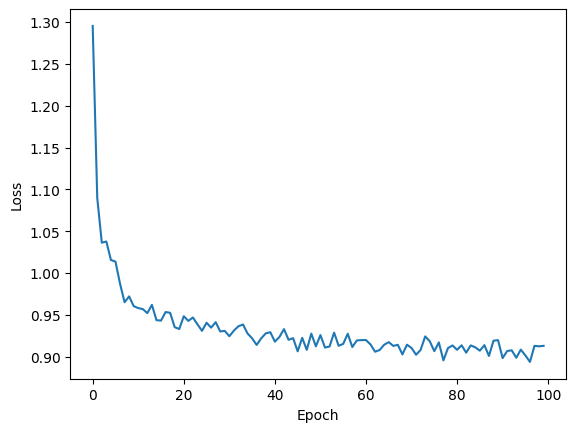

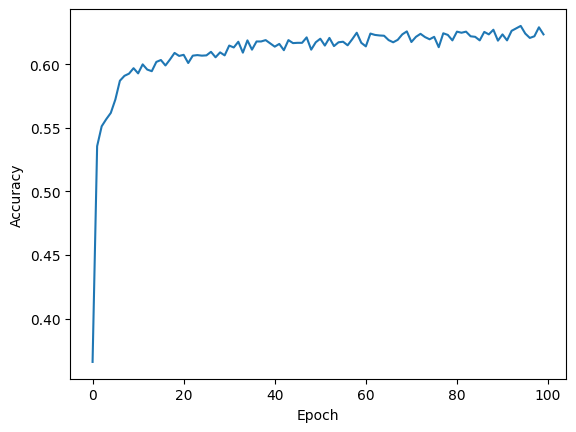

In [7]:
nn_model = train_nn(train_df_w_pca, epochs=100, batch_size=256, learning_rate=0.5, with_pca=True)

In [8]:
evaluate_nn(nn_model, train_df_w_pca, test_df_w_pca)

Accuracy for happy:
	Train data: 0.89
	Test data: 0.88
Accuracy for neutral:
	Train data: 0.79
	Test data: 0.32
Accuracy for angry:
	Train data: 0.28
	Test data: 0.01
Accuracy for sad:
	Train data: 0.23
	Test data: 0.21
Total accuracy:
	Train data: 0.63
	Test data: 0.42


## Handle the dataset without pca

In [9]:
train_df_wo_pca = pd.read_csv("train_wo_pca.csv")
test_df_wo_pca = pd.read_csv("test_wo_pca.csv")

Epoch 1: loss: 1.3407796307613975, accuracy: 0.3447018563747406
Epoch 2: loss: 1.1598716095874184, accuracy: 0.4757614731788635
Epoch 3: loss: 1.0463693832096301, accuracy: 0.5499785542488098
Epoch 4: loss: 1.000005028749767, accuracy: 0.5709995627403259
Epoch 5: loss: 0.9976024470831218, accuracy: 0.5845130681991577
Epoch 6: loss: 0.9689368793838903, accuracy: 0.5875160694122314
Epoch 7: loss: 0.9676757203905206, accuracy: 0.6006006002426147
Epoch 8: loss: 0.9514667015326651, accuracy: 0.5999571084976196
Epoch 9: loss: 0.9488402636427629, accuracy: 0.6051051020622253
Epoch 10: loss: 0.9492768739399157, accuracy: 0.60317462682724
Epoch 11: loss: 0.9433509644709135, accuracy: 0.6025310754776001
Epoch 12: loss: 0.9345312400868064, accuracy: 0.6098241209983826
Epoch 13: loss: 0.9444819657426131, accuracy: 0.6068211197853088
Epoch 14: loss: 0.9307188297572889, accuracy: 0.610253095626831
Epoch 15: loss: 0.9298203054227328, accuracy: 0.6078935861587524
Epoch 16: loss: 0.9258245857138383, ac

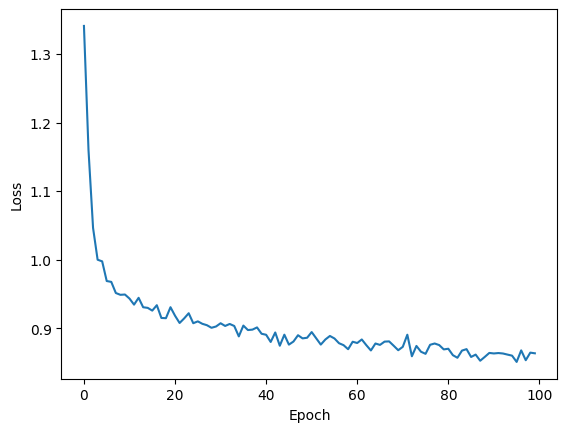

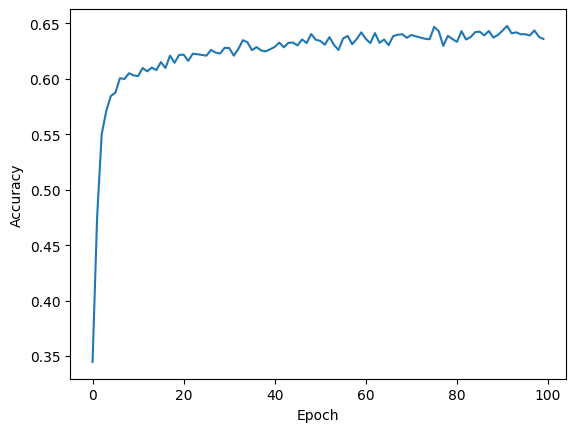

In [10]:
nn_model = train_nn(train_df_wo_pca, epochs=100, batch_size=256, learning_rate=0.5, with_pca=False)

In [11]:
evaluate_nn(nn_model, train_df_wo_pca, test_df_wo_pca)

Accuracy for happy:
	Train data: 0.91
	Test data: 0.89
Accuracy for neutral:
	Train data: 0.79
	Test data: 0.41
Accuracy for angry:
	Train data: 0.36
	Test data: 0.03
Accuracy for sad:
	Train data: 0.19
	Test data: 0.09
Total accuracy:
	Train data: 0.64
	Test data: 0.42
